In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", [gpu.name for gpu in gpus])

strategy = tf.distribute.MirroredStrategy()

Available GPUs: ['/physical_device:GPU:0', '/physical_device:GPU:1']


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, Dense, Add, Flatten, Reshape, LeakyReLU,ReLU
from tensorflow.keras.models import Model

# Define the generator model
def build_generator(input_shape, noise_dim):
    clean_image = Input(shape=input_shape, name="clean_image")
    noise_input = Input(shape=(1,), name="noise_level")
    
    # Embed the noise level to concatenate with the image
    noise_embedding = Dense(input_shape[0] * input_shape[1],activation='relu')(noise_input)
    noise_embedding = Reshape((input_shape[0], input_shape[1], 1))(noise_embedding)
    
    # Concatenate clean image and noise embedding
    x = Concatenate()([clean_image, noise_embedding])
    
    # Generator Convolutional Layers
    x1 = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu',name='x1')(x)
    x2 = Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu',name='x2')(x1)
    x3 = Conv2DTranspose(128, kernel_size=3, strides=1, padding='same', activation='relu',name='x3')(x2)

    x4 = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu',name='x4')(x3)
    x5 = Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu',name='x5')(Add()([x1,x4]))
    x6 = Conv2DTranspose(128, kernel_size=3, strides=1, padding='same', activation='relu',name='x6')(Add()([x2,x5]))
    
    # Output faded image
    faded_image = Conv2D(1, kernel_size=3, strides=1, padding='same', activation='relu',name='faded')(Add()([x3,x6]))
    
    generator = Model([clean_image, noise_input], faded_image, name="generator")
    return generator

# Define the discriminator model
def build_discriminator(input_shape):
    clean_image = Input(shape=input_shape, name="clean_image")
    faded_image = Input(shape=input_shape, name="faded_image")
    noise_input = Input(shape=(1,), name="noise_level")
    
    # Embed the noise level and concatenate with images
    noise_embedding = Dense(input_shape[0] * input_shape[1],activation='relu')(noise_input)
    noise_embedding = Reshape((input_shape[0], input_shape[1], 1))(noise_embedding)
    
    # Concatenate clean, faded image, and noise embedding
    x = Concatenate()([clean_image, faded_image, noise_embedding])
    
    # Discriminator Convolutional Layers
    x = Conv2D(256, kernel_size=3, strides=1, padding='same',activation='relu')(x)
    x = Conv2D(128, kernel_size=3, strides=1, padding='same',activation='relu')(x)
    x = Conv2D(64, kernel_size=3, strides=1, padding='same',activation='relu')(x)
    x = Conv2D(32, kernel_size=3, strides=1, padding='same',activation='relu')(x)
    x = Flatten()(x)
    
    # Output real/fake classification
    validity = Dense(1, activation='sigmoid')(x)
    
    discriminator = Model([clean_image, faded_image, noise_input], validity, name="discriminator")
    return discriminator

# Instantiate and compile the models
input_shape = (72, 14, 1)
noise_dim = 1

with strategy.scope():
    generator = build_generator(input_shape, noise_dim)
    discriminator = build_discriminator(input_shape)

    # Compile the discriminator
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # GAN model
    clean_image = Input(shape=input_shape, name="clean_image")
    noise_input = Input(shape=(1,), name="noise_level")
    faded_image = generator([clean_image, noise_input])

    validity = discriminator([clean_image, faded_image, noise_input])

    gan = Model([clean_image, noise_input], validity, name="cGAN")
    gan.compile(optimizer='adam', loss='binary_crossentropy')

# Model summary
generator.summary()
discriminator.summary()
gan.summary()


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ noise_level         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1008)      │      2,016 │ noise_level[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clean_image         │ (None, 72, 14, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 72, 14, 1) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 72, 14, 2) │          0 │ clean_image[0][0… │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x1 (Conv2D)         │ (None, 72, 14,    │      2,432 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x2 (Conv2D)         │ (None, 72, 14,    │    295,168 │ x1[0][0]          │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x3                  │ (None, 72, 14,    │    295,040 │ x2[0][0]          │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x4 (Conv2D)         │ (None, 72, 14,    │    147,584 │ x3[0][0]          │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 72, 14,    │          0 │ x1[0][0],         │
│                     │ 128)              │            │ x4[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x5 (Conv2D)         │ (None, 72, 14,    │    295,168 │ add[0][0]         │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 72, 14,    │          0 │ x2[0][0],         │
│                     │ 256)              │            │ x5[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x6                  │ (None, 72, 14,    │    295,040 │ add_1[0][0]       │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 72, 14,    │          0 │ x3[0][0],         │
│                     │ 128)              │            │ x6[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ faded (Conv2D)      │ (None, 72, 14, 1) │      1,153 │ add_2[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,333,601 (5.09 MB)

 Trainable params: 1,333,601 (5.09 MB)

 Non-trainable params: 0 (0.00 B)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ noise_level         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1008)      │      2,016 │ noise_level[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clean_image         │ (None, 72, 14, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ faded_image         │ (None, 72, 14, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 72, 14, 1) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 72, 14, 3) │          0 │ clean_image[0][0… │
│ (Concatenate)       │                   │            │ faded_image[0][0… │
│                     │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 72, 14,    │      7,168 │ concatenate_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 14,    │    295,040 │ conv2d[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 14,    │     73,792 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 72, 14,    │     18,464 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32256)     │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │     32,257 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 428,737 (1.64 MB)

 Trainable params: 428,737 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

Model: "cGAN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ clean_image         │ (None, 72, 14, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_level         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ generator           │ (None, 72, 14, 1) │  1,333,601 │ clean_image[0][0… │
│ (Functional)        │                   │            │ noise_level[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator       │ (None, 1)         │    428,737 │ clean_image[0][0… │
│ (Functional)        │                   │            │ generator[0][0],  │
│                     │                   │            │ noise_level[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,762,338 (6.72 MB)

 Trainable params: 1,762,338 (6.72 MB)

 Non-trainable params: 0 (0.00 B)

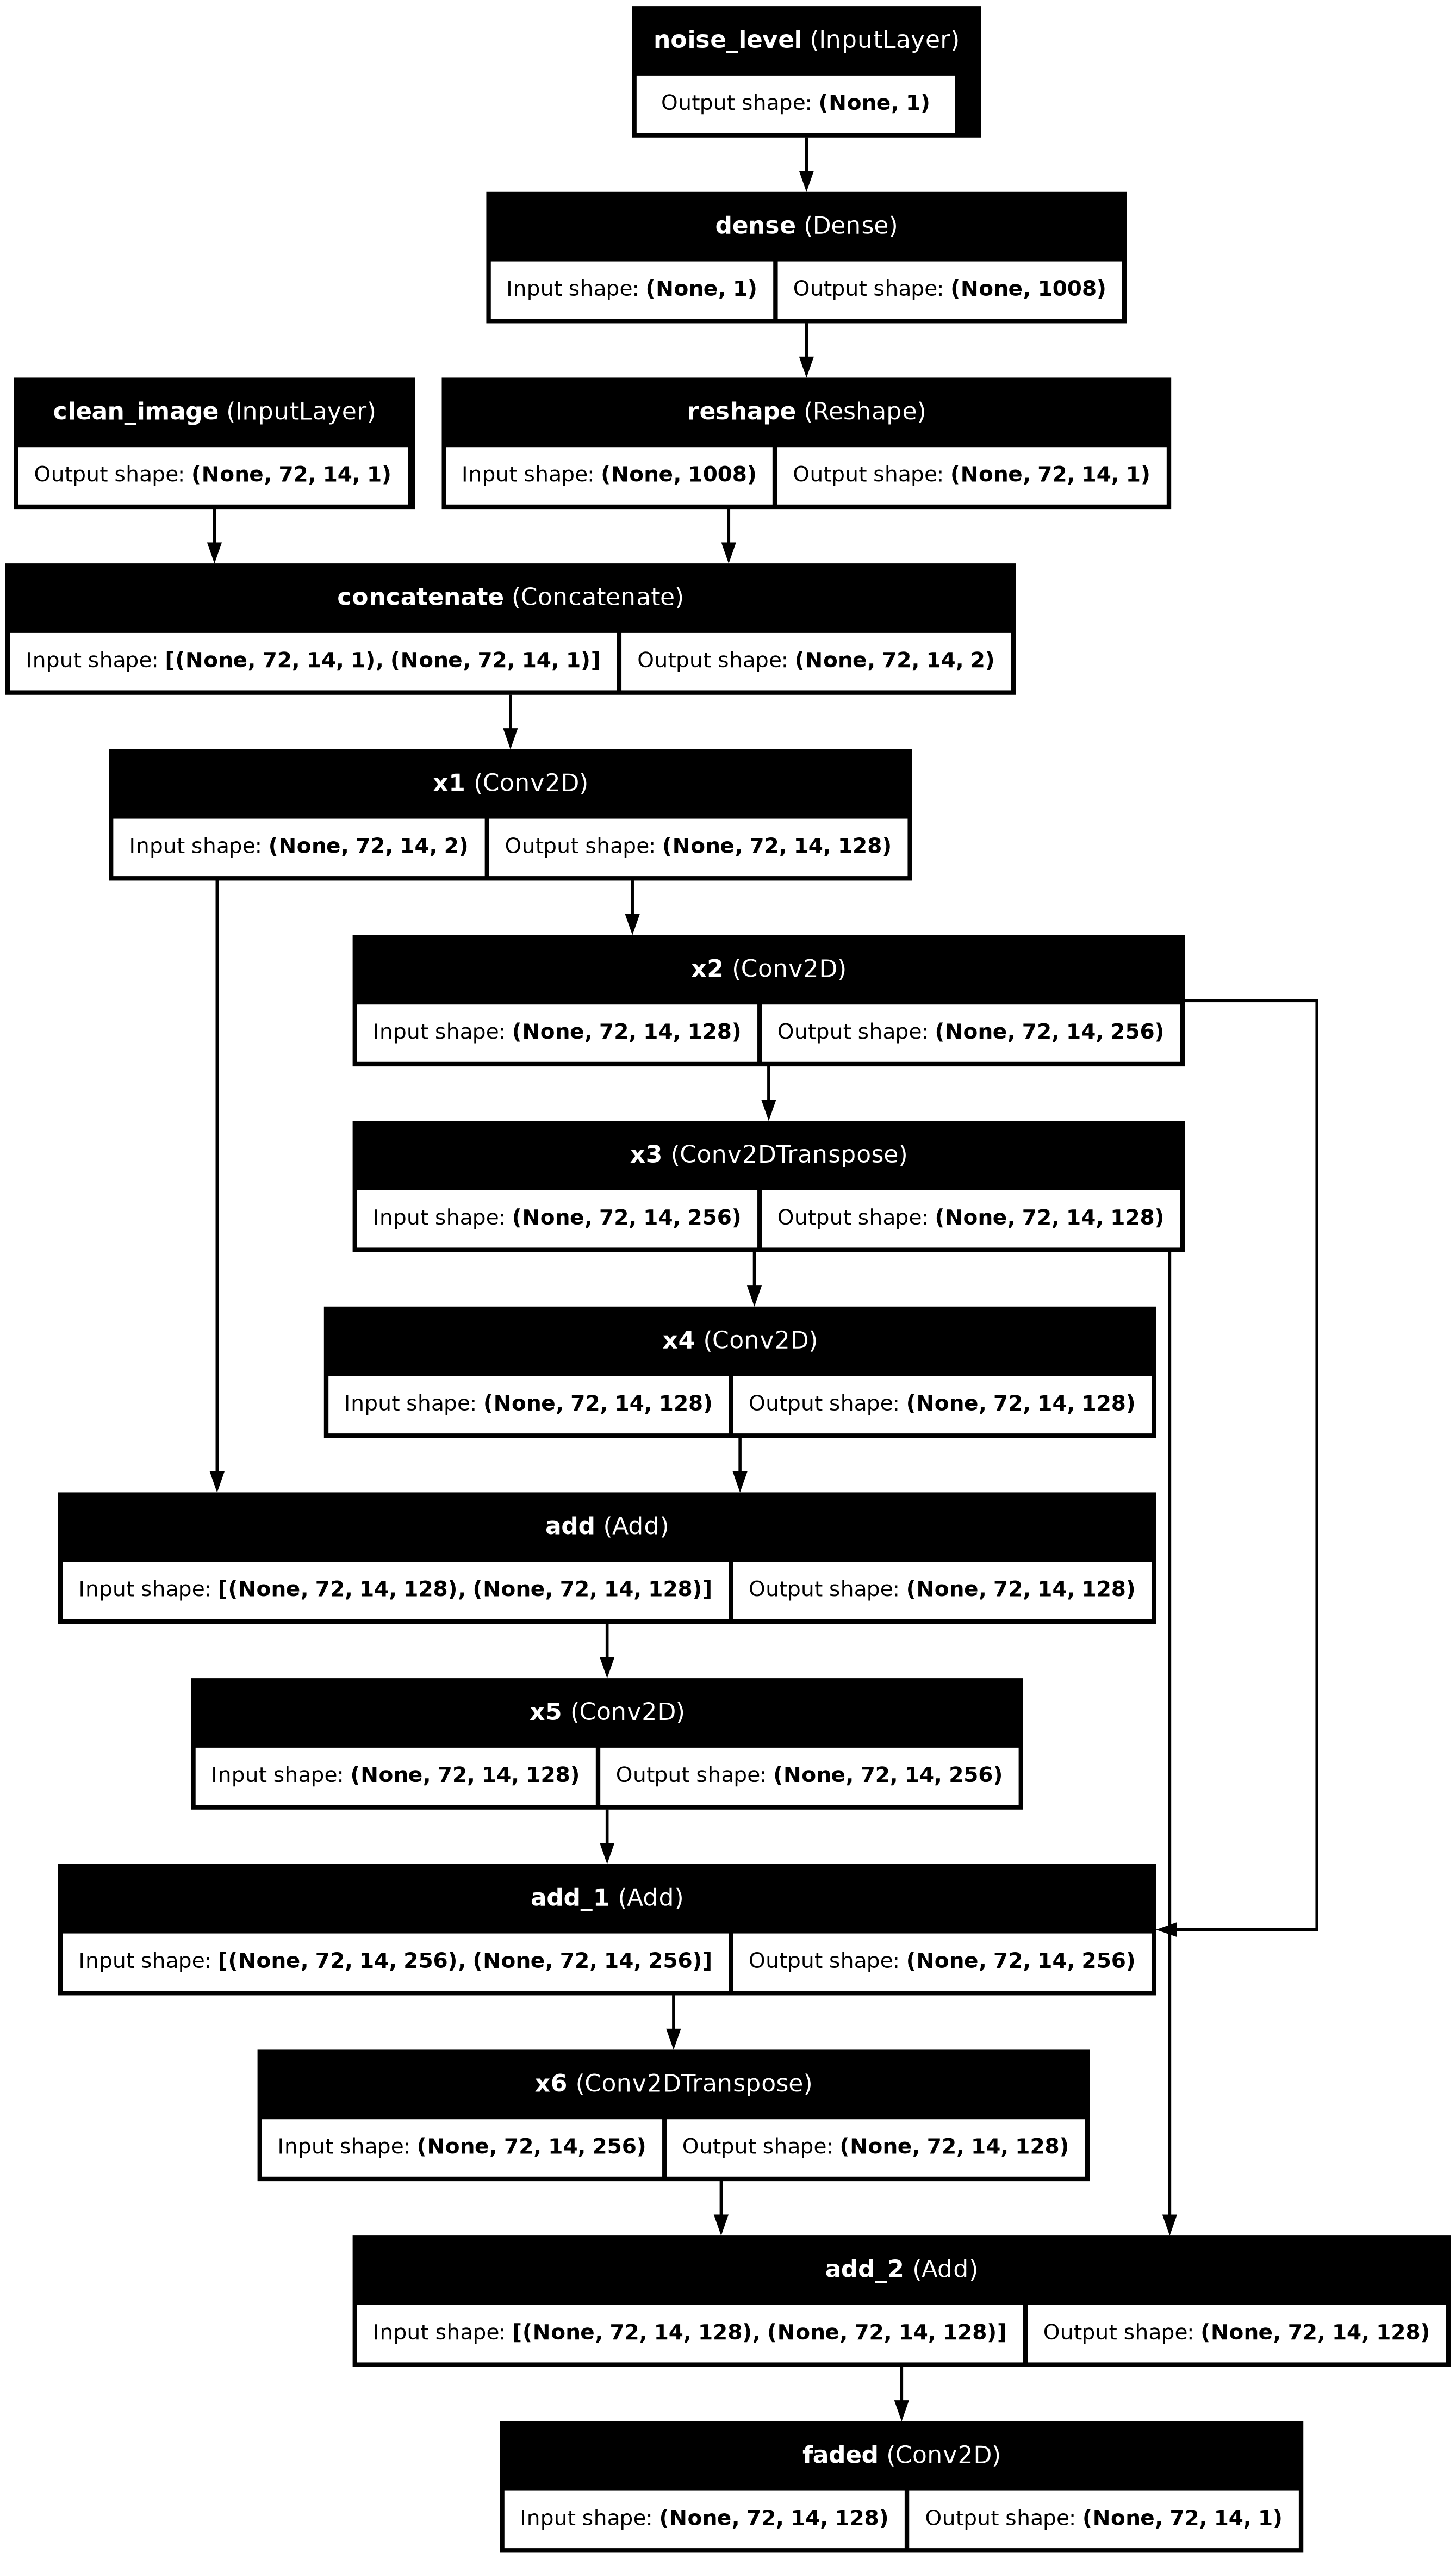

In [3]:
import keras
keras.utils.plot_model(generator,show_shapes=True,show_layer_names=True)

In [4]:
import numpy as np
clean_images=np.load('/kaggle/input/mehran-multi-db/mehran_allDB_data/perfect.npy')
faded_images=np.load('/kaggle/input/mehran-multi-db/mehran_allDB_data/noise.npy')
noise_levels=np.load('/kaggle/input/mehran-multi-db/mehran_allDB_data/snrs.npy')

In [5]:
batch_size = 64
epochs =250
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

In [6]:
from tqdm import tqdm
tf.get_logger().setLevel('ERROR')

# Set up to use the GPU if available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and will be used.")
else:
    print("GPU is not available. Running on CPU.")

# Training loop
for epoch in tqdm(range(epochs), desc="Training Progress"):
    # ---------------------
    #  Train Discriminator
    # ---------------------
    discriminator.trainable = True  # Enable training for the discriminator
    
    # Select a random batch of clean images, noise levels, and faded images
    idx = np.random.randint(0, len(clean_images), batch_size)
    clean_imgs, noise_lvls = clean_images[idx], noise_levels[idx]
    faded_imgs = faded_images[idx]
    
    # Generate a batch of faded images using the generator
    generated_imgs = generator.predict([clean_imgs, noise_lvls], verbose=0)

    # Train the discriminator (real classified as 1, fake as 0)
    d_loss_real = discriminator.train_on_batch([clean_imgs, faded_imgs, noise_lvls], real)
    d_loss_fake = discriminator.train_on_batch([clean_imgs, generated_imgs, noise_lvls], fake)
    
    # Calculate discriminator loss and accuracy
    d_loss = 2*(d_loss_real[0] + d_loss_fake[0])  # Discriminator loss
    d_acc = 0.25*(d_loss_real[1] + d_loss_fake[1])    # Discriminator accuracy

    # ---------------------
    #  Train Generator
    # ---------------------
    discriminator.trainable = False  # Freeze the discriminator weights

    # Train the generator (wants discriminator to label generated images as real)
    g_loss = 2*gan.train_on_batch([clean_imgs, noise_lvls], real)[0]  # Generator loss

    # Print the progress every 25 epochs
    if epoch % 20 == 0:
        print(f"\nEpoch {epoch}/{epochs} - D loss: {d_loss:.4f}, acc.: {100 * d_acc:.2f}%, G loss: {g_loss:.4f}")

GPU is available and will be used.


Training Progress:   0%|          | 1/250 [00:20<1:24:20, 20.33s/it]


Epoch 0/250 - D loss: 3.5959, acc.: 0.00%, G loss: 2.1540


Training Progress:   8%|▊         | 21/250 [01:04<08:27,  2.22s/it] 


Epoch 20/250 - D loss: 2.7470, acc.: 28.86%, G loss: 1.3643


Training Progress:  16%|█▋        | 41/250 [01:50<07:52,  2.26s/it]


Epoch 40/250 - D loss: 2.4454, acc.: 33.46%, G loss: 1.2168


Training Progress:  24%|██▍       | 61/250 [02:35<07:12,  2.29s/it]


Epoch 60/250 - D loss: 2.8048, acc.: 33.17%, G loss: 1.3978


Training Progress:  32%|███▏      | 81/250 [03:22<06:40,  2.37s/it]


Epoch 80/250 - D loss: 2.6510, acc.: 34.91%, G loss: 1.3250


Training Progress:  40%|████      | 101/250 [04:10<05:52,  2.37s/it]


Epoch 100/250 - D loss: 2.4829, acc.: 35.74%, G loss: 1.2393


Training Progress:  48%|████▊     | 121/250 [04:58<05:11,  2.41s/it]


Epoch 120/250 - D loss: 2.3717, acc.: 36.41%, G loss: 1.1856


Training Progress:  56%|█████▋    | 141/250 [05:46<04:24,  2.42s/it]


Epoch 140/250 - D loss: 2.2487, acc.: 37.19%, G loss: 1.1245


Training Progress:  64%|██████▍   | 161/250 [06:36<03:41,  2.49s/it]


Epoch 160/250 - D loss: 2.2007, acc.: 37.37%, G loss: 1.1003


Training Progress:  72%|███████▏  | 181/250 [07:26<02:52,  2.50s/it]


Epoch 180/250 - D loss: 2.1734, acc.: 37.51%, G loss: 1.0863


Training Progress:  80%|████████  | 201/250 [08:17<02:04,  2.54s/it]


Epoch 200/250 - D loss: 2.1529, acc.: 37.58%, G loss: 1.0760


Training Progress:  88%|████████▊ | 221/250 [09:09<01:14,  2.57s/it]


Epoch 220/250 - D loss: 2.1496, acc.: 37.51%, G loss: 1.0756


Training Progress:  96%|█████████▋| 241/250 [10:01<00:23,  2.61s/it]


Epoch 240/250 - D loss: 2.1450, acc.: 37.50%, G loss: 1.0722


Training Progress: 100%|██████████| 250/250 [10:25<00:00,  2.50s/it]


In [7]:
def generate_faded_image(clean_image, noise_level):
    # Ensure clean_image is in the shape (1, height, width, channels)
    # Add a batch dimension
    clean_image = np.expand_dims(clean_image, axis=0)
    print(np.shape(clean_image))
    
    # Prepare the noise level in the expected shape (1, )
    noise_level = np.array(noise_level, dtype=np.float32)

    # Generate the faded image using the generator
    faded_image = generator.predict([clean_image, noise_level])

    # Return the faded image (remove batch dimension)
    return faded_image[0]

(1,)
(1, 72, 14, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


17.306289575701157

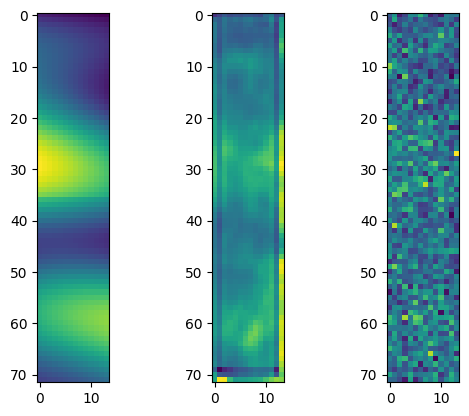

In [8]:
import matplotlib.pyplot as plt
ind=np.random.randint(40000)
print(np.shape([20.0]))
plt.subplot(1,3,1)
plt.imshow(clean_images[ind])
faded=generate_faded_image(clean_images[ind], [40.0]).astype('float64')
faded=faded/np.max(faded)

plt.subplot(1,3,2)
plt.imshow(faded)

plt.subplot(1,3,3)
plt.imshow(faded_images[ind])
import cv2
cv2.PSNR(clean_images[ind], faded,1.0)

(1, 72, 14, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


19.501773401424046

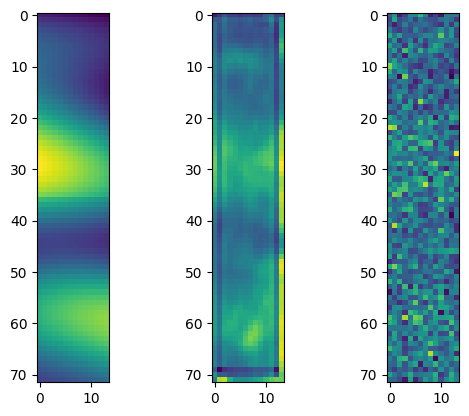

In [9]:
plt.subplot(1,3,1)
plt.imshow(clean_images[ind])
faded=generate_faded_image(clean_images[ind], [30.0]).astype('float64')
faded=faded/np.max(faded)

plt.subplot(1,3,2)
plt.imshow(faded)

plt.subplot(1,3,3)
plt.imshow(faded_images[ind])

import cv2
cv2.PSNR(clean_images[ind], faded,1.0)

(1, 72, 14, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


22.081096474823426

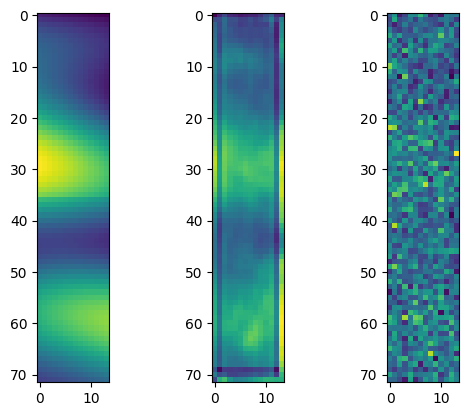

In [10]:
plt.subplot(1,3,1)
plt.imshow(clean_images[ind])
faded=generate_faded_image(clean_images[ind], [20.0]).astype('float64')
faded=faded/np.max(faded)

plt.subplot(1,3,2)
plt.imshow(faded)

plt.subplot(1,3,3)
plt.imshow(faded_images[ind])

cv2.PSNR(clean_images[ind], faded,1.0)

(1, 72, 14, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


22.415978681092632

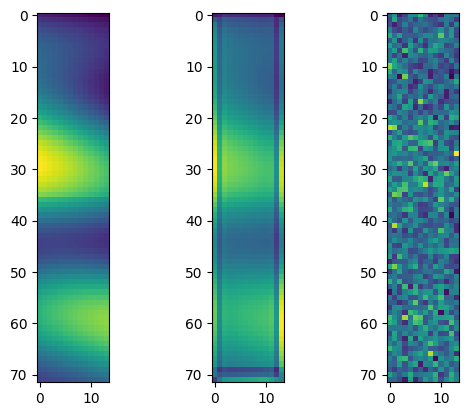

In [11]:
plt.subplot(1,3,1)
plt.imshow(clean_images[ind])
faded=generate_faded_image(clean_images[ind], [0.0]).astype('float64')
faded=faded/np.max(faded)

plt.subplot(1,3,2)
plt.imshow(faded)

plt.subplot(1,3,3)
plt.imshow(faded_images[ind])

cv2.PSNR(clean_images[ind], faded,1.0)

In [12]:
# import tensorflow as tf
# from tqdm import tqdm
# tf.get_logger().setLevel('ERROR')

# # Set the mixed precision policy to use mixed_float16
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

# # Print the current policy to confirm
# print("Current mixed precision policy:", tf.keras.mixed_precision.global_policy())

# # Set up to use the GPU if available
# if tf.config.list_physical_devices('GPU'):
#     print("GPU is available and will be used.")
# else:
#     print("GPU is not available. Running on CPU.")

# # Create a TensorFlow Dataset
# dataset = tf.data.Dataset.from_tensor_slices((clean_images, noise_levels, faded_images)).batch(batch_size)

# # Optimize dataset with prefetching
# dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# # Training loop
# for epoch in tqdm(range(epochs), desc="Training Progress"):
#     # ---------------------
#     #  Train Discriminator
#     # ---------------------
#     discriminator.trainable = True  # Enable training for the discriminator
    
#     for clean_imgs, noise_lvls, faded_imgs in dataset:
#         # Generate a batch of faded images using the generator
#         generated_imgs = generator.predict([clean_imgs, noise_lvls], verbose=0)

#         # Train the discriminator (real classified as 1, fake as 0)
#         d_loss_real = discriminator.train_on_batch([clean_imgs, faded_imgs, noise_lvls], real)
#         d_loss_fake = discriminator.train_on_batch([clean_imgs, generated_imgs, noise_lvls], fake)
        
#         # Calculate discriminator loss and accuracy
#         d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])  # Discriminator loss
#         d_acc = 0.5 * (d_loss_real[1] + d_loss_fake[1])    # Discriminator accuracy

#     # ---------------------
#     #  Train Generator
#     # ---------------------
#     discriminator.trainable = False  # Freeze the discriminator weights

#     # Train the generator (wants discriminator to label generated images as real)
#     g_loss = gan.train_on_batch([clean_imgs, noise_lvls], real)[0]  # Generator loss

#     # Print the progress every 100 epochs
#     if epoch % 8 == 0:
#         print(f"\nEpoch {epoch}/{epochs} - D loss: {d_loss:.4f}, acc.: {100 * d_acc:.2f}%, G loss: {g_loss:.4f}")